separate dataset to 10 sub-datasets according to the output class ... DONE <br/>
train 10 models for each output class ... DONE <br/>
store adv pictures for later usage ... <br/> 
overfit one-class PPRD (train: 1 adv; test: all advs) ... <br/> 
try to implement self-attention module ... <br/> 
try DRAW architecture ...  <br/>

In [1]:
import PI

meta_params = {
    'num_of_train_dataset': 1000,
    'num_of_test_dataset': 100,
    'is_flatten': False
}

PI = PI.PIInterface(meta_params)

import torch
import torch.nn as nn
import torch.optim as optim
from MNIST_models import *
# model = CNN()
# loss_func, optimizer = nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=1e-3)
# model = PI.train_model(model, loss_func, optimizer, 3)
# PI.set_model(model)
# print('train acc:', PI.eval_model('train'))
# print('test acc:', PI.eval_model('test'))
# print()

model = load_model('store/MNIST_CNN.pt')
PI.set_model(model)
print('train acc:', PI.eval_model('train'))
print('test acc:', PI.eval_model('test'))

1000 100
(100, 1, 28, 28)


C:\Users\nmake\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'MNIST_models.CNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\nmake\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\nmake\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.M

train acc: 0.991
test acc: 0.98


In [2]:
# # visualize the benign input and corresponding adv samples 
# samples, labels = PI.train_dataset

# %matplotlib inline
# from matplotlib import pyplot as plt
# import numpy as np
# import attacker
# import time
# import warnings
# warnings.filterwarnings('ignore')


# adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'L1PGD', 'L2PGD', 'LINFPGD', 'L2BI', 'LINFBI', 'ENL1', 'DDNL2', 'LBFGS', 'SP', 'LS', 'ST']
# print(len(adv_types))
# formatted_adv_types = [adv_type.ljust(6) for adv_type in adv_types]
# print('  '+' '.join(formatted_adv_types))

# figsize=(5, 5)
# fig=plt.figure(figsize=figsize)
# columns, num_of_rows = len(adv_types), 8

# for i in range(num_of_rows):
#     sample, label = samples[i], labels[i]
#     for col_index in range(columns):  
#         adv_type = adv_types[col_index]
#         if adv_type == 'None': 
#             plt_sample = sample 
#         else:
#             plt_sample = PI.generate_adv_img(sample, label, model, adv_type)
#             if plt_sample is None: 
#                 plt_sample = np.zeros((1, 28, 28)) 
            

#         fig.add_subplot(num_of_rows, columns, (col_index+1)+(i*columns))
#         plt.imshow(np.squeeze(plt_sample), cmap='gray')
#         plt.xticks([])
#         plt.yticks([])

# fig.savefig('out.png')

In [3]:
import pickle

# STORE
# adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'LINFPGD', 'LINFBI', 'ENL1', 'ST']
# adv_types = ['ENL1', 'ST']
# for adv_type in adv_types:
#     if adv_type == 'None': 
#         fn_name='store/normal.txt'
#         set_of_signatures = PI.generate_signatures() 
#     else: 
#         fn_name='store/'+adv_type+'.txt'
#         set_of_signatures = PI.generate_signatures(adv_type=adv_type)
    
#     print(adv_type, len(set_of_signatures))
#     with open(fn_name, "wb") as fp:   
#         pickle.dump(set_of_signatures, fp)
    
prefix = 'store/'    
# LOAD 
adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'LINFPGD', 'LINFBI', 'ENL1', 'ST']
set_of_train_dataset, set_of_test_dataset = [], []

for adv_type in adv_types:
    # extract from the store file 
    if adv_type == 'None': fn_name=prefix+'normal.txt'
    else: fn_name=prefix+adv_type+'.txt'
    fp = open(fn_name, 'rb')
    set_of_signatures = pickle.load(fp)
    
    # separate and store in for later training and evaluation 
    if adv_type == 'None': split_percentage = 0.1
    else: split_percentage = 0.1
    split_line = int(len(set_of_signatures)*split_percentage)
    train_set_of_signatures, test_set_of_signatures = set_of_signatures[:split_line], set_of_signatures[split_line:]
    set_of_train_dataset.append(train_set_of_signatures)
    set_of_test_dataset.append(test_set_of_signatures)
    fp.close()
    print(adv_type, len(set_of_signatures), len(train_set_of_signatures), len(test_set_of_signatures))
    
print()
filtered_adv_types = ['None', 'LINFPGD']
filtered_set_of_train_dataset = []
for adv_type in filtered_adv_types:
    # extract from the store file 
    if adv_type == 'None': fn_name=prefix+'normal.txt'
    else: fn_name=prefix+adv_type+'.txt'
    fp = open(fn_name, 'rb')
    set_of_signatures = pickle.load(fp)
    
    # separate and store in for later training and evaluation 
    if adv_type == 'None': split_percentage = 0.8
    else: split_percentage = 0.8
    split_line = int(len(set_of_signatures)*split_percentage)
    train_set_of_signatures, test_set_of_signatures = set_of_signatures[:split_line], set_of_signatures[split_line:]
    filtered_set_of_train_dataset.append(train_set_of_signatures)
    fp.close()
    print(adv_type, len(set_of_signatures), len(train_set_of_signatures), len(test_set_of_signatures))



None 1000 100 900
FGSM 813 81 732
JSMA 966 96 870
CWL2 877 87 790
LINFPGD 978 97 881
LINFBI 970 97 873
ENL1 1000 100 900
ST 991 99 892

None 1000 800 200
LINFPGD 978 782 196


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch

guard_model = Guard()
guard_model.train()

# set_of_train_dataset = filtered_set_of_train_dataset
epoches = 10

train_accs, test_accs, losses, set_train_sub_accs, set_test_sub_accs = train_guard_model(guard_model, set_of_train_dataset, set_of_test_dataset, adv_types, epoches)
losses = [x.item() for x in losses]
guard_model.eval()
# torch.save(guard_model, 'store/guard.pt')
# guard_model = torch.load('guard.pt')

benign correct: 24 / 100
adv ( FGSM ) correct: 81 / 81
adv ( JSMA ) correct: 96 / 96
adv ( CWL2 ) correct: 85 / 87
adv ( LINFPGD ) correct: 97 / 97
adv ( LINFBI ) correct: 95 / 97
adv ( ENL1 ) correct: 99 / 100
adv ( ST ) correct: 99 / 99
acc: 0.892998678996037

benign correct: 147 / 900
adv ( FGSM ) correct: 731 / 732
adv ( JSMA ) correct: 867 / 870
adv ( CWL2 ) correct: 779 / 790
adv ( LINFPGD ) correct: 868 / 881
adv ( LINFBI ) correct: 858 / 873
adv ( ENL1 ) correct: 891 / 900
adv ( ST ) correct: 878 / 892
acc: 0.8802281368821293

epoch: 1 loss: 468.8522033691406
acc (train): 0.892998678996037
acc (test): 0.8802281368821293

one epoch training time in seconds 25.0861363
benign correct: 80 / 100
adv ( FGSM ) correct: 81 / 81
adv ( JSMA ) correct: 96 / 96
adv ( CWL2 ) correct: 77 / 87
adv ( LINFPGD ) correct: 93 / 97
adv ( LINFBI ) correct: 93 / 97
adv ( ENL1 ) correct: 91 / 100
adv ( ST ) correct: 94 / 99
acc: 0.9313077939233818

benign correct: 376 / 900
adv ( FGSM ) correct: 728 /

Guard(
  (relu): ReLU()
  (pre_l1_conv1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (pre_l2_conv1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (pre_l3_conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh4): Linear(in_features=64, out_features=64, bias=True)
  (hh12): Conv2d(8, 8, kernel_size=(15, 15), stride=(1, 1))
  (hh23): Conv2d(8, 8, kernel_size=(8, 8), stride=(1, 1))
  (hh34): Linear(in_features=72, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

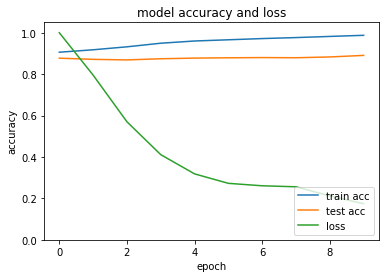

In [5]:
import copy
from scipy.ndimage.filters import gaussian_filter1d

smooth_train_accs = gaussian_filter1d(train_accs, sigma=1)
smooth_test_accs = gaussian_filter1d(test_accs, sigma=1)
smooth_losses = gaussian_filter1d(losses, sigma=1)
norm_smooth_losses = [float(i)/max(smooth_losses) for i in smooth_losses]

from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure()

# summarize history for accuracy
plt.plot(smooth_train_accs)
plt.plot(smooth_test_accs)
plt.plot(norm_smooth_losses)
plt.title('model accuracy and loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'test acc', 'loss'], loc='lower right')
plt.ylim([0, 1.05])

# plt.savefig('LINFPGD_training_process.jpg')
plt.show()

In [6]:
test_guard_model(guard_model, set_of_test_dataset, adv_types)

benign correct: 508 / 900
adv ( FGSM ) correct: 726 / 732
adv ( JSMA ) correct: 853 / 870
adv ( CWL2 ) correct: 700 / 790
adv ( LINFPGD ) correct: 850 / 881
adv ( LINFBI ) correct: 819 / 873
adv ( ENL1 ) correct: 830 / 900
adv ( ST ) correct: 853 / 892
acc: 0.8977771278151506


(0.8977771278151506,
 [0.5644444444444444,
  0.9918032786885246,
  0.9804597701149426,
  0.8860759493670886,
  0.9648127128263337,
  0.9381443298969072,
  0.9222222222222223,
  0.9562780269058296])

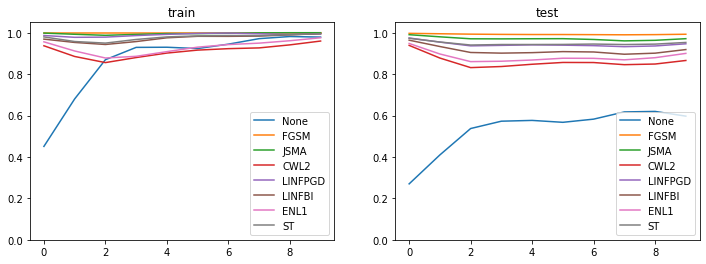

In [7]:
figsize = (12, 4)
fig=plt.figure(figsize=figsize)

num_of_epoches = len(set_train_sub_accs)
num_of_adv_types = len(set_train_sub_accs[0])
fig.add_subplot(1, 2, 1)
for i in range(num_of_adv_types):
    adv_type_accs = [sub_accs[i] for sub_accs in set_train_sub_accs]
    smooth_adv_type_accs = gaussian_filter1d(adv_type_accs, sigma=1)
    plt.plot(smooth_adv_type_accs)
    
# plt.legend(filtered_adv_types, loc='lower right')
plt.legend(adv_types, loc='lower right')
plt.title('train')
plt.ylim([0, 1.05])

num_of_epoches = len(set_test_sub_accs)
num_of_adv_types = len(set_test_sub_accs[0])
fig.add_subplot(1, 2, 2)
for i in range(num_of_adv_types):
    adv_type_accs = [sub_accs[i] for sub_accs in set_test_sub_accs]
    smooth_adv_type_accs = gaussian_filter1d(adv_type_accs, sigma=1)
    plt.plot(smooth_adv_type_accs)
    
plt.legend(adv_types, loc='lower right')
plt.title('test')
plt.ylim([0, 1.05])

# plt.savefig('LINFPGD_sub_accs.jpg')
plt.show()